# Draw Figure 9

Figure 9. As in Figure 4, except for MCS precipitation.

# Get analysis regions

In [1]:
from stats import get_analysis_regions

regions, region_names = get_analysis_regions()

region_names

{'EC': 'ECONUS',
 'NP': 'Northern Plains',
 'SP': 'Southern Plains',
 'MW': 'Midwest',
 'SE': 'Southeast',
 'NE': 'Northeast'}

# Create a masked version of the original data

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import xarray as xr
from stats import mask_data
import pandas as pd

data_dir = "../data"
analysis='mcs_precip'
subset='monthly'

show_regions = True

simulation_names = {'historical': 'HIST', 
                    'future_4p5': 'EoC 4.5',
                    'future_8p5': 'EoC 8.5'}

region_position = {'EC': 0, 'NP': 1, 'SP': 2, 
                   'MW': 3, 'SE': 4, 'NE': 5}
    
annual_cumulative = {}

pref = "../data"

for sim in simulation_names.keys():
        
    ds = xr.open_mfdataset(f"{data_dir}/{analysis}/{sim}_{subset}/mcs_precip*.nc")

    annual_cumulative[sim] = {}

    for region_id, region_states in regions.items():
        
        masked_data = mask_data(ds, states=region_states)
        masked_data = masked_data.compute()

        data = {}

        for yid, year in masked_data.resample(time='AS-OCT'):
              
            y = pd.to_datetime(yid).year

            year_mean = year.mean(('west_east', 'south_north'))
            year_mean = year_mean.sortby(year_mean.time.dt.month)
            data[y] = year_mean['mcs_precip'].cumsum().values

        d = pd.DataFrame.from_dict(data)

        d.index = np.array(list(range(1, 13)))

        d['mean'] = d.mean(axis=1)

        d['p25'] = d.quantile(0.25, axis=1)

        d['p75'] = d.quantile(0.75, axis=1)

        d['p50'] = d.quantile(0.5, axis=1)
        
        annual_cumulative[sim][region_id] = d

# Write out tables for each region and monthly cumulative MCS days, differences, and significant differences.

In [4]:
from scipy.stats import mannwhitneyu

from IPython.display import display, HTML

def highlight_max(p, props=''):
    
    return np.where(p < 0.05, props, '')

for region_id in regions.keys():

    hist_ = annual_cumulative['historical'][region_id][['mean']]
    hist_ = hist_.rename(columns={'mean': 'historical_mean'})
    
    rcp45_ = annual_cumulative['future_4p5'][region_id][['mean']]
    rcp45_ = rcp45_.rename(columns={'mean': 'future_4p5_mean'})
    
    rcp85_ = annual_cumulative['future_8p5'][region_id][['mean']]
    rcp85_ = rcp85_.rename(columns={'mean': 'future_8p5_mean'})

    combined = pd.concat([hist_, rcp45_, rcp85_],  axis=1)

    combined['future_4p5_diff'] = combined['future_4p5_mean'] - combined['historical_mean']
    combined['future_8p5_diff'] = combined['future_8p5_mean'] - combined['historical_mean']

    hist = annual_cumulative['historical'][region_id][list(range(1990, 2005))].values
    futr_45 = annual_cumulative['future_4p5'][region_id][list(range(2085, 2100))].values
    futr_85 = annual_cumulative['future_8p5'][region_id][list(range(2085, 2100))].values

    _, p45 = mannwhitneyu(hist, futr_45, axis=1)
    _, p85 = mannwhitneyu(hist, futr_85, axis=1)

    combined['future_4p5_p'] = p45
    combined['future_8p5_p'] = p85

    combined.index.name = "Month-End Accumulation" 

    c = combined.style.apply(highlight_max, props='background-color:red', subset=['future_4p5_p', 'future_8p5_p'], axis=0)

    html_str = f"<h1>{region_names[region_id]}</h1>"
    display(HTML(html_str))
    display(HTML(c.to_html()))

,historical_mean,future_4p5_mean,future_8p5_mean,future_4p5_diff,future_8p5_diff,future_4p5_p,future_8p5_p
Month-End Accumulation,,,,,,,
1,13.841112,13.404411,9.893145,-0.436700,-3.947967,0.455302,0.803463
2,33.062983,28.290795,26.879874,-4.772188,-6.183109,0.648204,0.561447
3,51.255926,48.640159,49.534597,-2.615768,-1.721329,0.966915,0.803463
4,80.673641,77.785515,76.981305,-2.888126,-3.692335,0.900971,0.771551
5,129.143197,126.241456,122.352019,-2.901742,-6.791178,0.966915,0.803463
6,171.989495,169.013674,157.288474,-2.975821,-14.701021,1.000000,0.319506
7,207.001862,186.833904,178.030105,-20.167959,-28.971757,0.480731,0.074496
8,226.969620,202.563888,196.929261,-24.405732,-30.040360,0.406787,0.061970
9,243.477150,214.477472,207.890112,-28.999677,-35.587038,0.245485,0.081495


,historical_mean,future_4p5_mean,future_8p5_mean,future_4p5_diff,future_8p5_diff,future_4p5_p,future_8p5_p
Month-End Accumulation,,,,,,,
1,0.136660,0.102778,0.056644,-0.033882,-0.080015,0.573621,0.608952
2,0.359314,0.327401,0.294088,-0.031913,-0.065226,0.798575,0.883488
3,1.660662,1.138788,5.077299,-0.521874,3.416637,0.360426,0.004168
4,7.059988,8.009487,14.029914,0.949498,6.969926,0.648204,0.018067
5,24.814654,27.244333,40.289908,2.429680,15.475254,0.648204,0.007016
6,59.572418,58.114001,77.657939,-1.458417,18.085521,0.771551,0.025103
7,89.426304,84.587667,105.215637,-4.838636,15.789333,0.455302,0.158465
8,105.356824,99.972509,117.148562,-5.384316,11.791738,0.561447,0.319506
9,111.571776,104.414180,123.410514,-7.157597,11.838737,0.455302,0.383733


,historical_mean,future_4p5_mean,future_8p5_mean,future_4p5_diff,future_8p5_diff,future_4p5_p,future_8p5_p
Month-End Accumulation,,,,,,,
1,3.897355,5.180004,9.267957,1.282650,5.370602,0.205337,0.084842
2,12.620791,14.444475,26.453661,1.823684,13.832870,1.000000,0.089018
3,24.658368,31.582199,56.186314,6.923831,31.527946,0.678302,0.002823
4,40.208814,61.222766,100.390306,21.013951,60.181492,0.074496,0.000028
5,71.392578,93.849368,144.430609,22.456790,73.038030,0.158465,0.000009
6,112.953053,131.519765,188.964618,18.566712,76.011565,0.280842,0.000068
7,154.051637,169.829545,227.655466,15.777908,73.603829,0.430648,0.000115
8,179.104956,196.459282,249.822071,17.354326,70.717116,0.506915,0.000422
9,195.720088,211.349593,269.040374,15.629505,73.320286,0.708923,0.000361


,historical_mean,future_4p5_mean,future_8p5_mean,future_4p5_diff,future_8p5_diff,future_4p5_p,future_8p5_p
Month-End Accumulation,,,,,,,
1,38.911652,43.118534,50.627950,4.206882,11.716298,0.740022,0.383733
2,86.291505,93.185825,115.784900,6.894320,29.493395,0.771551,0.184410
3,132.078488,146.661924,186.544305,14.583436,54.465817,0.803463,0.012822
4,177.207074,199.046409,245.413256,21.839334,68.206182,0.618670,0.018067
5,208.064288,233.907663,275.274493,25.843375,67.210205,0.618670,0.018067
6,238.007139,270.547863,310.769386,32.540723,72.762246,0.506915,0.007940
7,271.332254,311.625239,348.691466,40.292985,77.359212,0.383733,0.034397
8,295.814455,332.130032,370.296723,36.315577,74.482267,0.406787,0.031017
9,307.197232,342.489393,378.838602,35.292161,71.641370,0.361496,0.031017


,historical_mean,future_4p5_mean,future_8p5_mean,future_4p5_diff,future_8p5_diff,future_4p5_p,future_8p5_p
Month-End Accumulation,,,,,,,
1,2.719121,6.292360,9.365573,3.573238,6.646452,0.042111,0.003691
2,5.817603,13.049456,18.166355,7.231853,12.348752,0.158465,0.001215
3,11.586479,26.358554,33.083613,14.772075,21.497134,0.022531,0.000115
4,17.868580,37.760094,54.279147,19.891513,36.410567,0.003230,0.000028
5,27.750654,47.095557,67.395675,19.344903,39.645021,0.008972,0.000006
6,40.564363,64.369815,92.871741,23.805452,52.307378,0.001404,0.000004
7,58.229014,91.915341,129.604355,33.686327,71.375341,0.000097,0.000005
8,70.133162,110.577466,147.693649,40.444304,77.560487,0.000081,0.000006
9,74.363969,120.397597,154.093594,46.033628,79.729624,0.000040,0.000005


,historical_mean,future_4p5_mean,future_8p5_mean,future_4p5_diff,future_8p5_diff,future_4p5_p,future_8p5_p
Month-End Accumulation,,,,,,,
1,14.091926,15.872250,18.529251,1.780323,4.437324,0.533829,0.361496
2,32.889998,35.026337,44.402243,2.136339,11.512245,0.740022,0.097091
3,52.503721,59.418248,77.834994,6.914528,25.331274,0.319506,0.004210
4,75.959198,89.498076,114.867616,13.538878,38.908418,0.262753,0.000422
5,106.463440,121.494493,149.548428,15.031053,43.084988,0.280842,0.000081
6,140.831697,156.525639,186.394542,15.693941,45.562845,0.340086,0.000081
7,174.270574,188.238799,219.432114,13.968225,45.161540,0.455302,0.000494
8,195.269981,208.626179,239.029558,13.356199,43.759577,0.406787,0.000780
9,207.730880,219.878048,250.621292,12.147168,42.890412,0.430648,0.000780


# Generate cumulative counts figure

## Set up customizations

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import matplotlib.patches as mpatches
#for panel labeling
import calendar
import string
letters = string.ascii_lowercase
label_props = dict(boxstyle='round', facecolor='w', alpha=1)

#modify the default boxplot
meanpointprops = dict(marker='.', markeredgecolor='black',
                      markerfacecolor='black')

#What color to give each box
simulation_color_codes = {'historical': '#B3D1AC', 
                          'future_4p5': '#6baed6', 
                          'future_8p5': '#a50f15'}

#Custom legend markers
import matplotlib.lines as mlines

rc45_mark_mwu = mlines.Line2D([], [], color='k', marker='^', linestyle='None',
                          markersize=8)

rc85_mark_mwu = mlines.Line2D([], [], color='k', marker='s', linestyle='None',
                          markersize=8)

hist_patch = mpatches.Patch(color=simulation_color_codes['historical'], label='HIST')
rcp45_patch = mpatches.Patch(color=simulation_color_codes['future_4p5'], label='EoC 4.5')
rcp85_patch = mpatches.Patch(color=simulation_color_codes['future_8p5'], label='EoC 8.5')

linestyle = {'historical': 'solid',
             'future_4p5': 'dotted',
             'future_8p5': 'dashed'}

inset_params = {'xticks': list(range(0, 12, 2)), 
                'xticklabels': [calendar.month_abbr[m] for m in range(1, 13, 2)],
                'xlim': (0, 11), 'ylim': (0, 600), 
                'ylabel': 'mm', 'bounds': [0.57, 0.07, 0.4, 0.2]}

## Plot cumulative counts

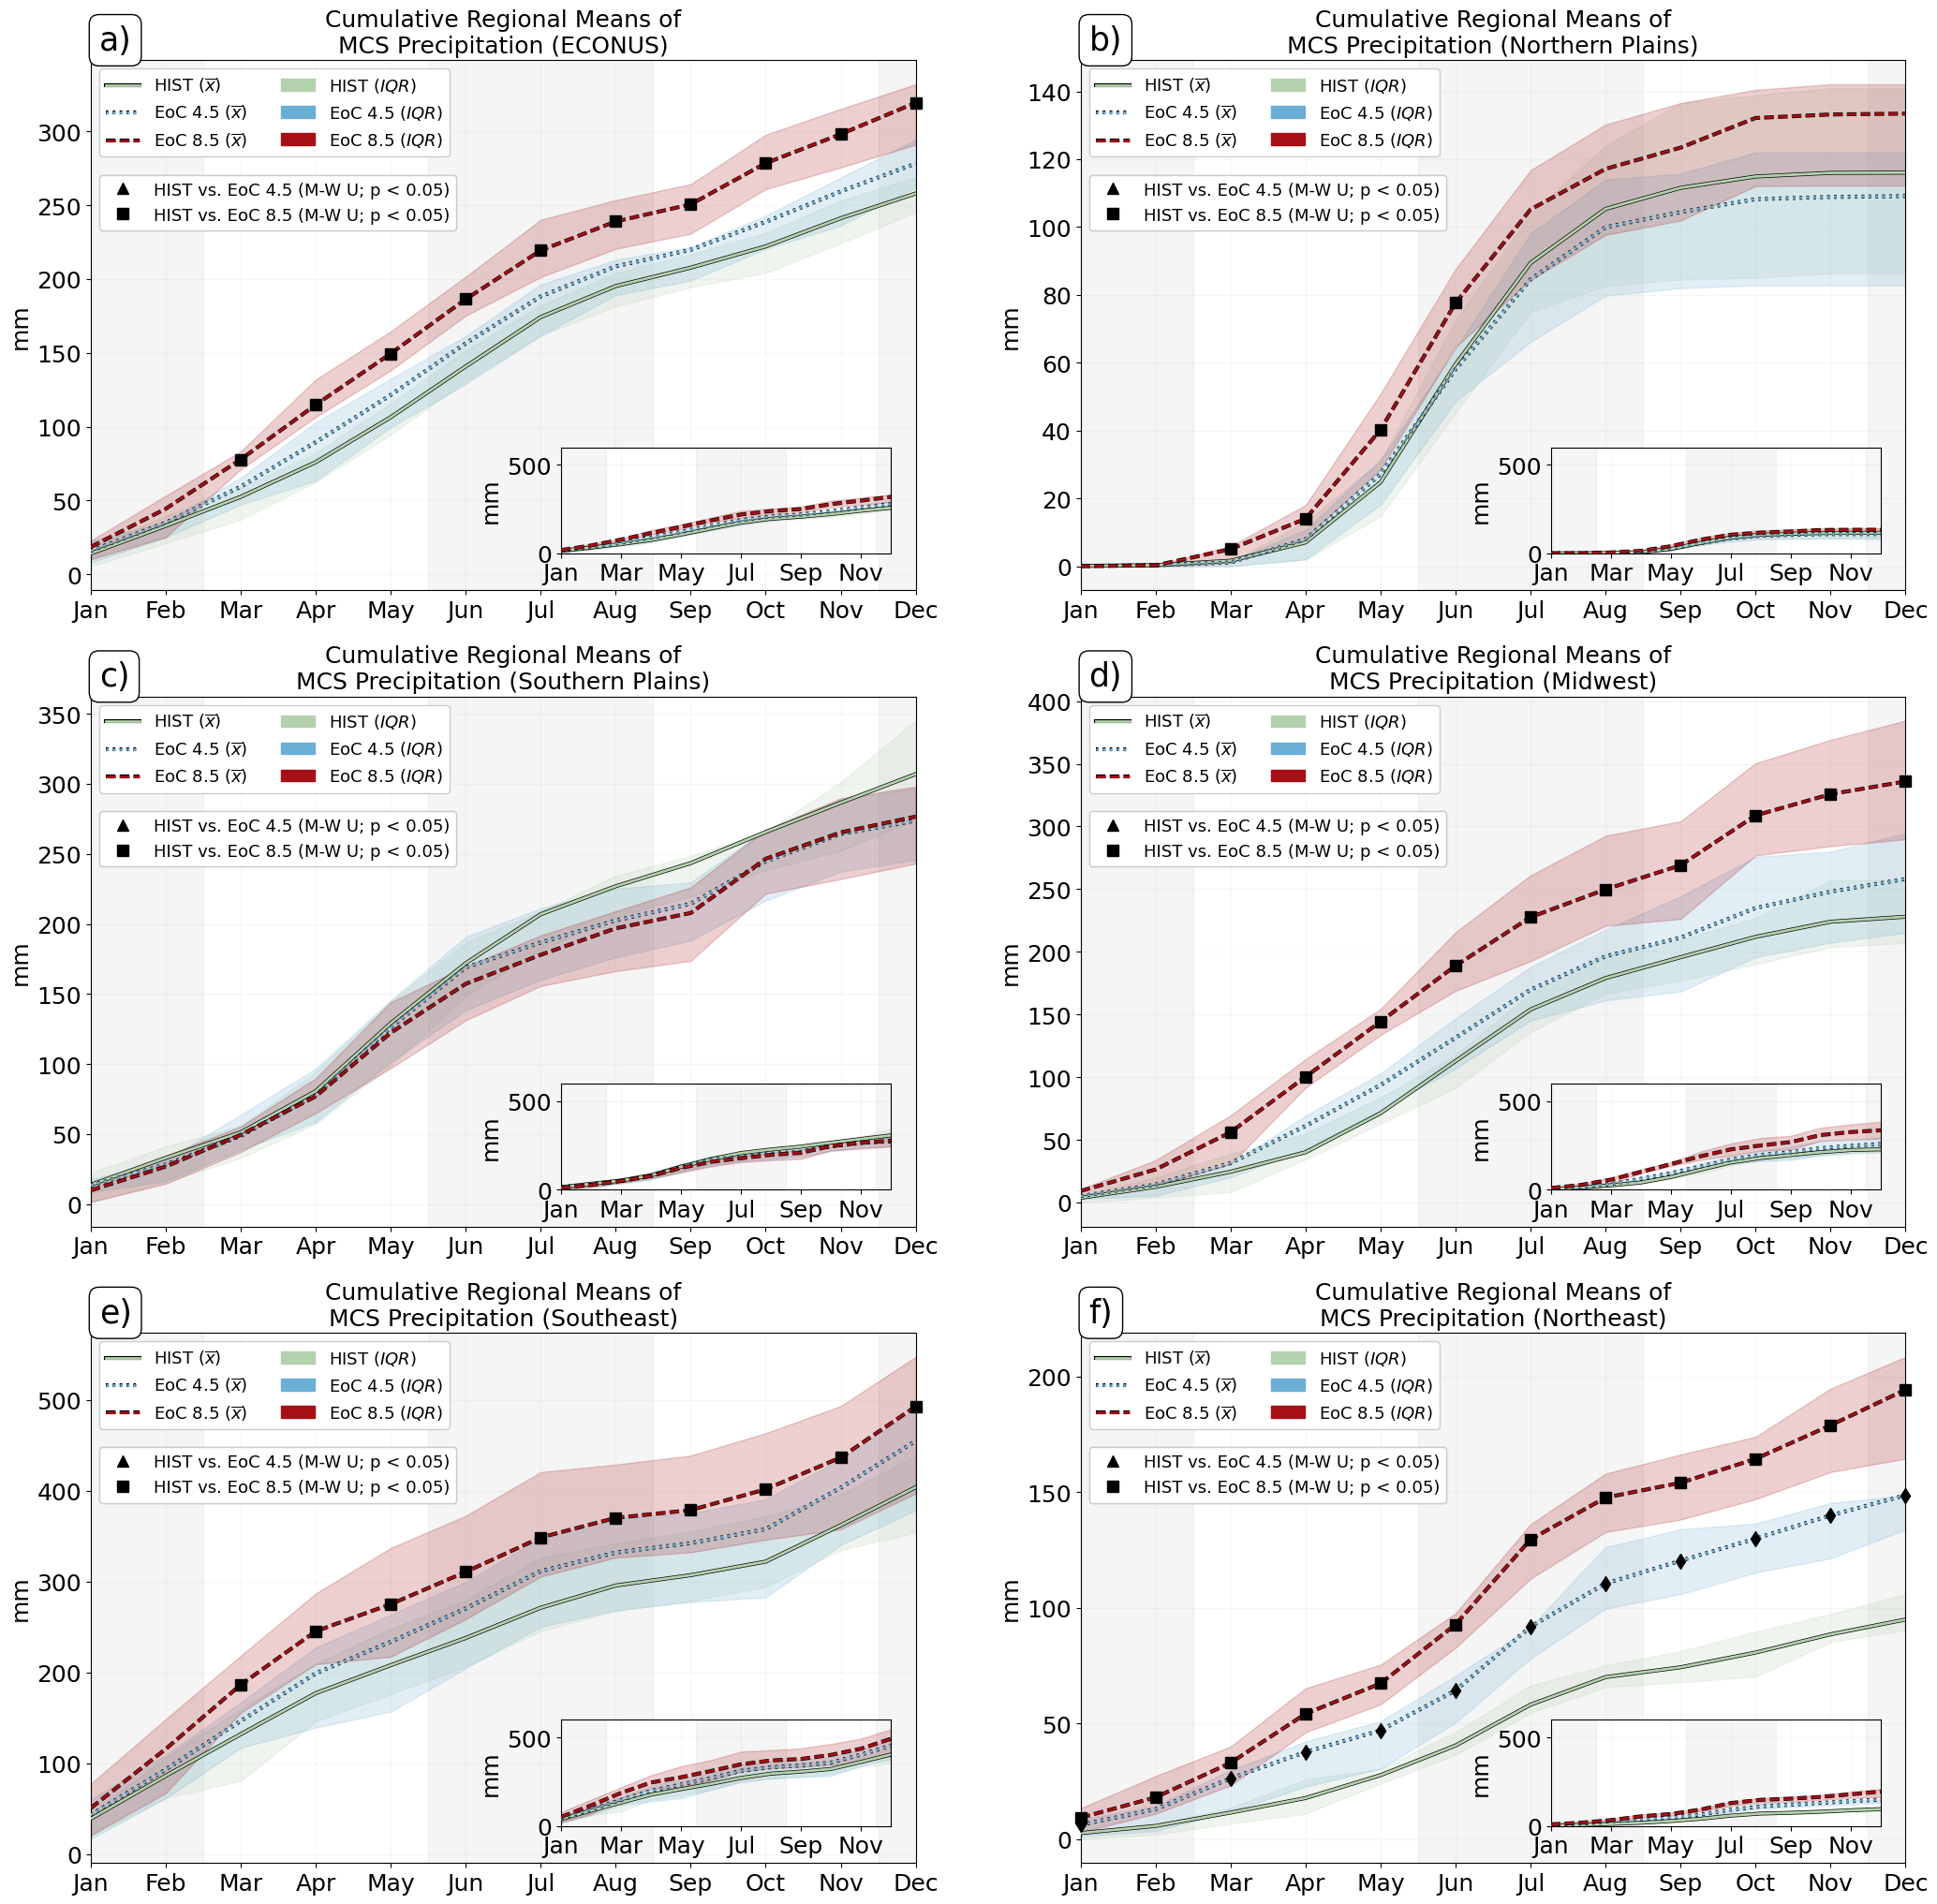

In [6]:
#Set figure size and some fontsizes
plt.rcParams['figure.figsize'] = 25, 25
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18

import matplotlib.patheffects as pe

for figure_position, (region_id, region_name) in enumerate(region_names.items()):
    
    ax = plt.subplot(3, 2, figure_position+1)
    
    ax.annotate(f"{letters[figure_position]})", (0.01,1.02), xycoords='axes fraction',
                   fontsize=25, bbox=label_props, color='k', zorder=25)
        
    ax.set_title(f"Cumulative Regional Means of\nMCS Precipitation ({region_names[region_id]})")
    
    ax.set_xlim(0, 11)
    
    ax.axvspan(-.5, 1.5, color='grey', alpha=0.075)
    ax.axvspan(4.5, 7.5, color='grey', alpha=0.075)
    ax.axvspan(10.5, 11.5, color='grey', alpha=0.075)
    
    ax.set_xticks(list(range(0, 12)))
    ax.set_xticklabels([calendar.month_abbr[m] for m in range(1, 13)])
    
    ax.grid(alpha=0.1)
    
    ax.set_ylabel("mm")
    
    ltemp = {}



    axins = ax.inset_axes(**inset_params)

    axins.axvspan(-.5, 1.5, color='grey', alpha=0.075)
    axins.axvspan(4.5, 7.5, color='grey', alpha=0.075)
    axins.axvspan(10.5, 11.5, color='grey', alpha=0.075)
    axins.grid(alpha=0.1)


    for ls, simulation in enumerate(['historical', 'future_4p5', 'future_8p5']):

        sim_sub = annual_cumulative[simulation][region_id].copy()

        lt = ax.plot(sim_sub['mean'].values, color=simulation_color_codes[simulation], ls=linestyle[simulation], 
                     lw=2, label=simulation_names[simulation], path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()],
                     zorder=6)
    
        ltemp[simulation] = lt
        
        ax.fill_between(list(range(0, 12)), y1=sim_sub['p25'].values, y2=sim_sub['p75'].values, 
                         color=simulation_color_codes[simulation], alpha=0.2)

        axins.plot(sim_sub['mean'].values, color=simulation_color_codes[simulation], ls=linestyle[simulation], 
                     lw=2, label=simulation_names[simulation], path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()],
                     zorder=6)
            
        axins.fill_between(list(range(0, 12)), y1=sim_sub['p25'].values, y2=sim_sub['p75'].values, 
                             color=simulation_color_codes[simulation], alpha=0.2)    
        
    for ix, mix in enumerate(range(1, 13)):
        
        hist_ = annual_cumulative['historical'][region_id].loc[mix][list(range(1990, 2005))].values
        r45_ = annual_cumulative['future_4p5'][region_id].loc[mix][list(range(2085, 2100))].values
        r85_ = annual_cumulative['future_8p5'][region_id].loc[mix][list(range(2085, 2100))].values
        
        _, ph45 = mannwhitneyu(hist_, r45_)
        _, ph85 = mannwhitneyu(hist_, r85_)

        if ph45 < 0.05:
            m45 = ax.plot(ix, np.mean([r45_]), "kd", ms=8, zorder=7, clip_on=False)

        if ph85 < 0.05:
            m85 = ax.plot(ix, np.mean([r85_]), "ks", ms=8, zorder=7, clip_on=False)

        
    leg1 = ax.legend([ltemp['historical'][0], ltemp['future_4p5'][0], ltemp['future_8p5'][0],
                hist_patch, rcp45_patch, rcp85_patch],
              ['HIST ($\overline{x}$)', 'EoC 4.5 ($\overline{x}$)', 'EoC 8.5 ($\overline{x}$)',
               'HIST ($IQR$)', 'EoC 4.5 ($IQR$)', 'EoC 8.5 ($IQR$)'], 
              loc='upper left', prop={'size':13}, framealpha=1, 
               ncol=2) 
    
    leg2 = ax.legend([rc45_mark_mwu, rc85_mark_mwu], 
                     ['HIST vs. EoC 4.5 (M-W U; p < 0.05)', 'HIST vs. EoC 8.5 (M-W U; p < 0.05)'],
                     loc='upper left', prop={'size':13}, framealpha=1, ncol=1, bbox_to_anchor=(0, 0.8))
                     
    plt.gca().add_artist(leg1)
    plt.gca().add_artist(leg2)
    
#plt.savefig("Figure_9.png", dpi=200, bbox_inches='tight')